In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
from mpdaf.obj import Cube
from mpdaf.obj import deg2sexa
import pandas as pd
import pyneb as pn
from astropy import visualization as viz
from astropy.visualization.mpl_normalize import ImageNormalize
from Packages.plot_lines import PlotLines
import matplotlib.patches as patches
from scipy.interpolate import interp1d
from IPython.core.display import display, HTML
from astropy import visualization as viz
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import pickle
from matplotlib.lines import Line2D
from Packages.plot_lines import PlotLines

/tmp/ipykernel_1432600/11513797.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#important diagnostic lines; include also H_alpha and H_beta
label = ['Halpha', 'Hbeta','[NII]', '[NII]', '[SII]', '[SII]', '[ClIII]', '[ClIII]', '[SIII]', '[SIII]']   
line_list = [6562.8, 4861.32, 5754.64, 6548.04, 6730.82, 6716.44,  5517.71,5537.88,  6312.06, 9068.60]  


#RANGE SETTINGS; copy paste to other section

#----------------------------------------------------

# line fit range
d_l = [6.5,  9, 6.5, 7, 6, 6, 5.5,   6.5, 6,   10] #adjust min and max of fit
d_r = [8, 9, 7, 5, 7, 5,  6.5,  6.5, 6, 10]
   
# continuum range and width
d_cont_l = [50, 45, 28, 23, 9, 25, 28, 15, 7, 21]
delta_l  = [25, 25, 18, 15, 5, 15, 18, 10, 3, 10]
d_cont_r = [40, 35, 15, 45, 15, 5, 5.5, 8, 10, 12]
delta_r  = [20, 15, 15, 15, 10, 5, 8, 15, 15, 10]
   
# limes of the plot    
xlim_l = [60, 50, 15, 25, 20, 17, 20, 20, 20, 27 ] 
xlim_r = [60, 70, 15, 60, 21, 20, 30, 20, 20, 30 ]

# choose how many random pixels to analyse
#num_pix = 1
#pix_i = np.random.randint(1, 250, size=num_pix)
#pix_j = np.random.randint(1, 350, size=num_pix)
 
#--------------------------------------------------

# 1. Use PyNeb for correction extinction -> go with this

In [3]:
import pyneb as pn

cube = Cube('../MUSE_data/muse-hr-fullcube-rebin05x05.fits')
 
ratio_theo = 2.89 #I(Halpha)/I(Hbeta); taken from Weilbacher 

#MASKED ARRAYS THAT ARE BEING FILLED WITH VALUES FOR EACH PIXEL
#---------------------------------------------------

#correction extinction(used to plot the dust map)
c_Hb = np.ma.masked_array(np.empty((295, 353)), mask = True) # acess c(Hbeta) for each pixel with c[i,j]; make masked array so that when I assign masked values it doesn't turn it into nan

#create cube object with corrected and normalised fluxes 
cube_cor = np.ma.masked_array(np.empty((5614, 295, 353)), mask = True) #normalised and extinction corrected 3D array but not in the origional cube format

#--------------------------------------------------

# entire range
n=1
m=294
q=1
r=352

    
#REDDENING CORRECTION
    
# initialize PyNeb with Balgrave extinction law and Rv for Orion 
rc = pn.RedCorr(R_V = 5.5,law = 'CCM89 Bal07')


for i in range(n, m):        #chose entire range (0,295) once I have access to server
    for j in range(q,r):    #chose entire range (0,353)
        sp = cube[:, i, j]      #entire wavelength spectrum for pixel (i,j)
        flux = sp.data
        lam = sp.wave.coord()
        
        # ignore masked pixels 
        if sp.data[0] is np.ma.masked: #ignore masked pixels, values remains masked - np.ma.masked 
            continue 

        # REDDENING CORRECTION
        
        # compute c for the pixel by fitting H lines
        f_H = []  #first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux

                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 3:
                print('S/N <3', i, j )
                continue

            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=False)
                #line_fit.print_param()
                f_H.append(line_fit.flux) 
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 

         
        if len(f_H) != 2:   # in order to stop loop when f_H could not be determined for both H lines
            continue



        # use PyNeb to determine c and do the correction
        ratio_obs = f_H[0]/f_H[1]                            # observed flux ratio between H_alpha and H_beta 
        rc.setCorr(obs_over_theo = ratio_obs/ratio_theo, wave1=6563., wave2=4861.)   #Halpha/Hbeta
        c = rc.cHbeta  #cHbeta
        
        c_Hb[i,j] = c  

 
        # correct spectrum for extinction and store data in cube_cor array 
        
        # relative to Hbeta
        cor = rc.getCorrHb(lam)
        intensity = flux*cor              # correct fluxes by correction factor 
        
        cube_cor[:,i,j] = np.array(intensity)

print('Done computing')

# SAVE DATA AS ARRAYS

pickle.dump(c_Hb, open('Stored_data/c_Hb.pkl', 'wb'))
pickle.dump(cube_cor, open('Stored_data/cube_cor.pkl', 'wb'))

print('Data are saved')

S/N <3 68 36
S/N <3 69 35
S/N <3 69 36
S/N <3 69 36
S/N <3 69 37
S/N <3 70 34
S/N <3 70 35
S/N <3 70 35
S/N <3 70 36
S/N <3 70 36
S/N <3 70 37
S/N <3 70 37
S/N <3 71 35
S/N <3 71 36
S/N <3 71 37
S/N <3 71 88
S/N <3 71 89
S/N <3 72 87
S/N <3 72 88
S/N <3 72 89
S/N <3 72 90
S/N <3 73 87
S/N <3 73 88
S/N <3 73 89
S/N <3 73 89
S/N <3 73 90
S/N <3 74 87
S/N <3 74 88
S/N <3 74 89
S/N <3 167 184
S/N <3 167 184
S/N <3 167 185
S/N <3 168 183
S/N <3 168 184
S/N <3 169 184
S/N <3 173 172
S/N <3 173 173
S/N <3 174 172
S/N <3 174 173
S/N <3 175 173
S/N <3 176 193
S/N <3 176 194
S/N <3 177 194
S/N <3 183 189
S/N <3 184 189


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation
S/N <3 262 351
S/N <3 265 177
S/N <3 266 121


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation


/tmp/ipykernel_1432600/2736199851.py:82: RuntimeWarning: invalid value encountered in scalar divide
  if S/N < 3:


Error occurent:Error in fwhm estimation
Done computing
Data are saved


# Testing for one pixel + plotting

[INFO] Gaussian center = 6563.1 (error:0.0108092)
[INFO] Gaussian integrated flux = 2.41901e+07 (error:204702)
[INFO] Gaussian peak value = 8.72374e+06 (error:11421.5)
[INFO] Gaussian fwhm = 2.60497 (error:0.0254544)
[INFO] Gaussian continuum = 1568.58
[INFO] Gaussian center = 4861.44 (error:0.00705325)
[INFO] Gaussian integrated flux = 5.68532e+06 (error:30281.1)
[INFO] Gaussian peak value = 1.97769e+06 (error:1629.58)
[INFO] Gaussian fwhm = 2.70062 (error:0.0166093)
[INFO] Gaussian continuum = 2345.05


166 19
FWhm 2.604969247116046 Err [%] 0.8462238285310955
FWhm 2.7006213729320265 Err [%] 0.5326191421213481
0.7635641661954699
0.7841632003666782
Done computing
Data are saved


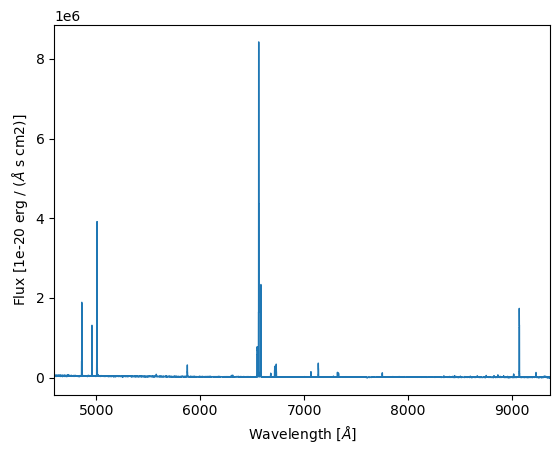

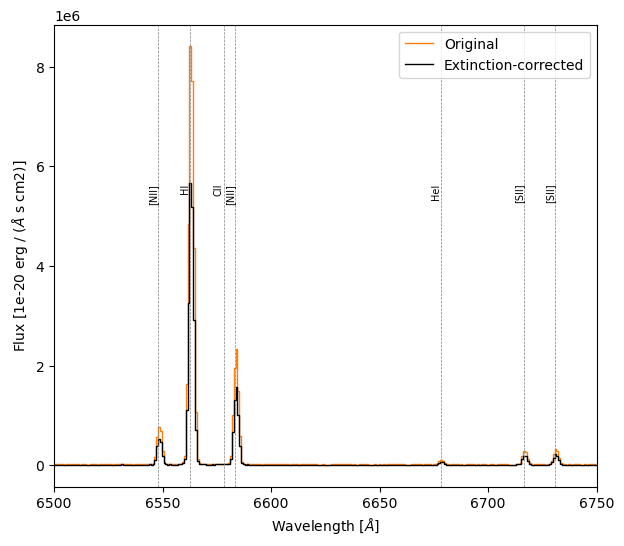

In [13]:
import pyneb as pn

cube = Cube('../MUSE_data/muse-hr-fullcube-rebin05x05.fits')
 
ratio_theo = 2.89 #I(Halpha)/I(Hbeta)

#MASKED ARRAYS THAT ARE BEING FILLED WITH VALUES FOR EACH PIXEL
#---------------------------------------------------

#correction extinction(used to plot the dust map)
c_Hb = np.ma.masked_array(np.empty((295, 353)), mask = True) # acess c(Hbeta) for each pixel with c[i,j]; make masked array so that when I assign masked values it doesn't turn it into nan

#create cube object with corrected and normalised fluxes 
cube_cor = np.ma.masked_array(np.empty((5614, 295, 353)), mask = True) #normalised and extinction corrected 3D array but not in the origional cube format

#--------------------------------------------------

# entire range
#n=1
#m=294
#q=1
#r=352

n = 200
m = 210
q = 50
r = 60

num_pix = 1
pix_i = np.random.randint(1, 250, size=num_pix)
pix_j = np.random.randint(1, 350, size=num_pix)

    
#REDDENING CORRECTION AND NORMALISATION
    
# initialize PyNeb with Balgrave extinction law 
rc = pn.RedCorr(R_V = 5.5,law = 'CCM89 Bal07')


for i in pix_i:# range(n, m):        #chose entire range (0,295) once I have access to server
    for j in pix_j:# range(q,r):    #chose entire range (0,353)

        print(i,j)
        sp = cube[:, i, j]      #entire wavelength spectrum for pixel (i,j)
        flux = sp.data
        lam = sp.wave.coord()

        plt.figure()
        sp.plot()
        plt.xlabel('Wavelength [$\AA$]')
        plt.ylabel('Flux [1e-20 erg / ($\AA$ s cm2)]')
     

        plt.figure(figsize=(7,6))
        sp.plot(color = 'C1', label = 'Original')
  

        
        # ignore masked pixels 
        if sp.data[0] is np.ma.masked: #ignore masked pixels, values remains masked - np.ma.masked 
            continue 

        # REDDENING CORRECTION
        
        # compute c for the pixel by fitting H lines
        f_H = []  #first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux

                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 3:
                print('S/N <3', i, j )
                continue

            
            #plt.figure()
            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=False)
                line_fit.print_param()
                f_H.append(line_fit.flux) 
                print('FWhm', line_fit.fwhm, 'Err [%]', line_fit.err_flux/line_fit.flux*100)
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 

         
        if len(f_H) != 2:   #in order to stop loop when f_H could not be determined for both H lines
            continue
        
        ratio_obs = f_H[0]/f_H[1]                               # observed flux ratio between H_alpha and H_beta 
        rc.setCorr(obs_over_theo=  ratio_obs/ratio_theo, wave1=6563., wave2=4861.)   #Halpha/Hbeta
        c = rc.cHbeta  #cHbeta
        
        c_Hb[i,j] = c  
        print(c)

        ratio_obs = f_H[0]/f_H[1]                               # observed flux ratio between H_alpha and H_beta 
        rc.setCorr(obs_over_theo=  ratio_obs/2.86, wave1=6563., wave2=4861.)   #Halpha/Hbeta
        c = rc.cHbeta  #cHbeta

        print(c)
        # correct spectrum for extinction and store data in cube_cor array 
        
        # not relative to Hbeta
        cor = rc.getCorrHb(lam)
        intensity = flux*cor #correct fluxes by correction factor 
        
        cube_cor[:,i,j] = np.array(intensity)
        sp.data = cube_cor[:,i,j]
        plt.xlabel('Wavelength [$\AA$]')
        plt.ylabel('Flux [1e-20 erg / ($\AA$ s cm2)]')

        # plotting 
        
        sp.plot(label = 'Extinction-corrected', color = 'black')
        PlotLines.plot_all_lines(6500, 6750, np.max(sp.data)*1)
        #plt.plot(lam, flux, color = 'C0', label='Original')
        #plt.plot(lam, intensity, label = 'Extinction-corrected', color = 'black')
        plt.xlabel('Wavelength [$\AA$]')
        plt.ylabel('Flux [1e-20 erg / ($\AA$ s cm2)]')
        plt.xlim(6500, 6750)
        plt.legend(loc=1)


print('Done computing')

# SAVE DATA AS ARRAYS

#pickle.dump(c_Hb, open('Stored_data/c_Hb.pkl', 'wb'))
#pickle.dump(cube_cor, open('Stored_data/cube_cor.pkl', 'wb'))

print('Data are saved')


# 2. Using self-written functions -> doesn't perform as good

## Extinction correction and normalisation of the spectra

In [4]:
#use extinction coeff from Blagrave; take values from tabel 2 and interpolate

lam_list = [4388  ,4400  ,4471 ,4713 ,4861, 4922  ,4959  ,5007  ,5016  ,5500  ,5518  ,5538  ,5755  ,5876  ,6548  ,6563 ,6583  ,6678  ,6716  ,6731  ,7065  ,7136  ,7236  ,7254 ,7281  ,7319  ,7330  ,9229 ,9464  ,9546]
f_lam = [0.078,0.076,0.064,0.024,0.000,-0.009,-0.015,-0.022,-0.024,-0.091,-0.093,-0.096,-0.123,-0.138,-0.218,-0.220,-0.222,-0.233,-0.238,-0.239,-0.278,-0.286,-0.298,-0.300,-0.303,-0.307,-0.309,-0.507,-0.529,-0.537]

def f(lam):
    return np.interp(lam, lam_list, f_lam)

# for theoretical intensity of Halpha/Hbeta take mean of values from Blagrave  ---> 2.8327
ratio_theo = 2.89 #I(Halpha)/I(Hbeta)


def flux_cor(flux_obs, c, f):   # c is c(hbeta) reddening constant, f(lam) is extinction law; convention to call intensity the reddening corrected flux 
    return flux_obs * 10 ** ((1-c)*f)





In [5]:
#load cube

cube = Cube('../MUSE_data/muse-hr-fullcube-rebin05x05.fits')
 
    

#MASKED ARRAYS THAT ARE BEING FILLED WITH VALUES FOR EACH PIXEL
#---------------------------------------------------

#correction extinction(used to plot the dust map)
c_Hb = np.ma.masked_array(np.empty((295, 353)), mask = True) # acess c(Hbeta) for each pixel with c[i,j]; make masked array so that when I assign masked values it doesn't turn it into nan

#create cube object with corrected and normalised fluxes 
cube_cor = np.ma.masked_array(np.empty((5614, 295, 353)), mask = True) #normalised and extinction corrected 3D array but not in the origional cube format

#--------------------------------------------------

# entire range
n=1
m=294
q=1
r=352

    
#REDDENING CORRECTION AND NORMALISATION
    
    
for i in range(n, m):        #chose entire range (0,295) once I have access to server
    for j in range(q,r):    #chose entire range (0,353)
        
        sp = cube[:, i, j]      #entire wavelength spectrum for pixel (i,j)
        flux = sp.data
        lam = sp.wave.coord()
        
        # ignore masked pixels 
        if sp.data[0] is np.ma.masked: #ignore masked pixels, values remains masked - np.ma.masked 
            continue 

        # REDDENING CORRECTION
        
        # compute c for the pixel by fitting H lines
        f_H = []  #first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux

                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 3:
                print('S/N <3', i, j )
                continue

            
            #plt.figure()
            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=False)
                #line_fit.print_param()
                f_H.append(line_fit.flux) 
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 

         
        if len(f_H) != 2:   #in order to stop loop when f_H could not be determined for both H lines
            continue
        
        ratio_obs = f_H[0]/f_H[1]                               # observed flux ratio between H_alpha and H_beta 
        c = 1/f(6562.8)*np.log10(ratio_theo/ratio_obs)        # c(Hbeta) reddening const; this is wrong! I wrote 1/f(6562.8) before but in Montero it is also an extra - f(hbeta); but no, it i right becasue f(hbeta) = 0 
        c_Hb[i,j] = c  
       
        # CORRECTED SPECTRUM FOR EXTINCTION + NORMALISATION
        
        intensity = flux_cor(flux, c, f(lam))/f_H[1]*100  #normalise by H_beta flux and multiply by 100
        cube_cor[:,i,j] = np.array(intensity)

print('Done computing')

# SAVE DATA AS ARRAYS

#pickle.dump(c_Hb, open('Stored_data/c_Hb.pkl', 'wb'))
#pickle.dump(cube_cor, open('Stored_data/cube_cor.pkl', 'wb'))

print('Data are saved')

KeyboardInterrupt: 

# Comparing PyNeb and my function

Flux H_alpha and H_alpha/H_beta before correction 7.567613524637035 5.430924096894681
1.24549592528498
cHb Pyneb 1.2453388802802285
My functions: Halpha_flux and Halpha/Hbeta 7.621624431565957 6.149897820273207
PyNeb: Halpha_flux and Halpha/Hbeta 7.293675493647174 2.890435926579953
Done computing


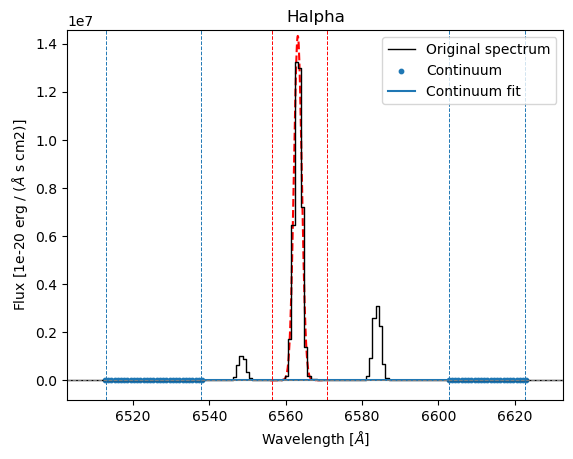

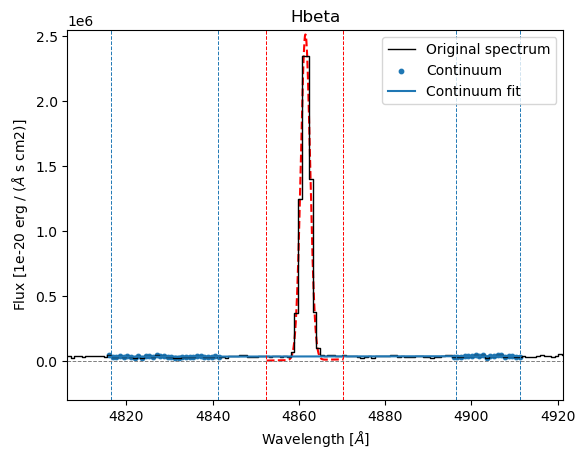

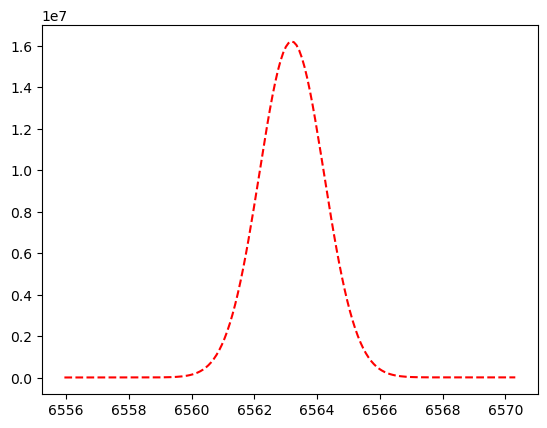

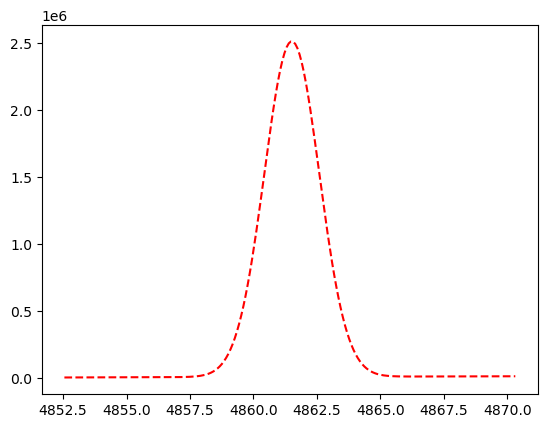

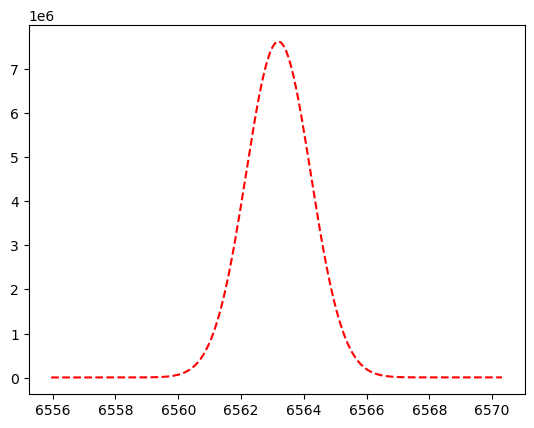

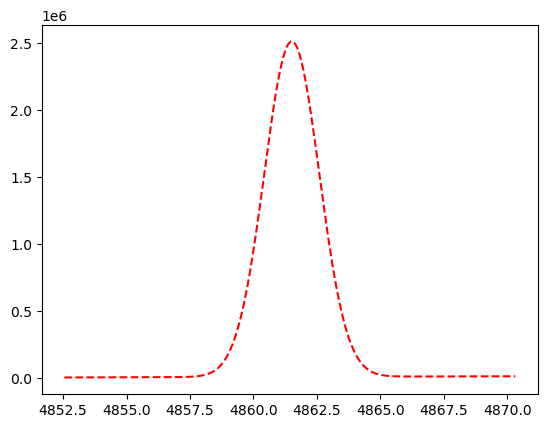

In [143]:
#load cube

cube = Cube('../MUSE_data/muse-hr-fullcube-rebin05x05.fits')
 
    

#MASKED ARRAYS THAT ARE BEING FILLED WITH VALUES FOR EACH PIXEL
#---------------------------------------------------

#correction extinction(used to plot the dust map)
c_Hb = np.ma.masked_array(np.empty((295, 353)), mask = True) # acess c(Hbeta) for each pixel with c[i,j]; make masked array so that when I assign masked values it doesn't turn it into nan

#create cube object with corrected and normalised fluxes 
cube_cor = np.ma.masked_array(np.empty((5614, 295, 353)), mask = True) #normalised and extinction corrected 3D array but not in the origional cube format
#intensities from pyneb
intensity_pyneb = np.ma.masked_array(np.empty((5614, 295, 353)), mask = True) #normalised and extinction corrected 3D array but not in the origional cube format

flux_Halpha = np.ma.masked_array(np.empty((295, 353)), mask = True) # uncorrected unnormalizied continuum-subtractred H_alpha fluxes
flux_Halpha_cor = np.ma.masked_array(np.empty((295, 353)), mask = True) # corrected continuum-subtractred H_alpha fluxes (intensities)

#--------------------------------------------------

# entire range
n=230
m=231
q=50
r=53

num_pix = 1
pix_i = np.random.randint(1, 250, size=num_pix)
pix_j = np.random.randint(1, 350, size=num_pix)

    
#REDDENING CORRECTION AND NORMALISATION
    
    
for i in pix_i:# range(n, m):        #chose entire range (0,295) once I have access to server
    for j in pix_j:#range(q,r):    #chose entire range (0,353)
        
        sp = cube[:, i, j]      #entire wavelength spectrum for pixel (i,j)
        flux = sp.data
        lam = sp.wave.coord()
        
        # ignore masked pixels 
        if sp.data[0] is np.ma.masked: #ignore masked pixels, values remains masked - np.ma.masked 
            continue 

        # REDDENING CORRECTION
        
        # compute c for the pixel by fitting H lines
        f_H = []  #first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux

                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 3:
                print('S/N <3.5', i, j )
                continue

            
            plt.figure()
            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=True)
                #line_fit.print_param()
                f_H.append(line_fit.flux) 
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 




            # Plotting to check fit of lines
 
            #plot original spectra and fitted continuum
            sp.plot(color='black', label = 'Original spectrum')
            plt.scatter(lam_cont, cont, label='Continuum', s = 10)
            plt.plot(lam_cont, cont_fit, label='Continuum fit')

             # Create a custom legend entry (thick dashed red line)
            legend_entry = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Fit')

            # Add the custom legend entry
           
        
                 
            plt.axvline(cont_start_l, color = 'C0', linewidth = 0.7, linestyle = 'dashed')
            plt.axvline(cont_end_l,  color = 'C0', linewidth = 0.7, linestyle = 'dashed')
            plt.axvline(cont_start_r, color = 'C0', linewidth = 0.7, linestyle = 'dashed')
            plt.axvline(cont_end_r, color = 'C0', linewidth = 0.7, linestyle = 'dashed')
            plt.axvline(lmin, color='red', linewidth = 0.7, linestyle = 'dashed')
            plt.axvline(lmax, color='red', linewidth = 0.7, linestyle = 'dashed')
            plt.axhline(0, color='grey', linewidth = 0.7, linestyle = 'dashed')     
            
            plt.title(f'{label[jj]}')   
            plt.ylabel('Flux [1e-20 erg / ($\AA$ s cm2)]')
            plt.xlabel('Wavelength [$\AA$]')
            plt.xlim(line - d_cont_l[jj]-10, cont_end_r+10)
            if jj == 0: 
                plt.ylim(-0.8e6, 1.1*np.max(sp_l.data))
            else:
                plt.ylim(-3e5, 1.1*np.max(sp_l.data))
            
            #plt.legend(handles=[legend_entry])
            plt.legend()

        flux_Halpha[i,j] = f_H[0] # save flux of uncorected Halpha lines
        print('Flux H_alpha and H_alpha/H_beta before correction', np.log10(f_H[0]), f_H[0]/f_H[1])
        
         
        if len(f_H) != 2:   #in order to stop loop when f_H could not be determined for both H lines
            continue
        
        ratio_obs = f_H[0]/f_H[1]                             # observed flux ratio between H_alpha and H_beta 
        c = 1/f(6562.8)*np.log10(ratio_theo/ratio_obs)        # c(Hbeta) reddening const; this is wrong! shoudl be a -, instead of adding it here, add it in the function for the red correction
        print(c)
        c_Hb[i,j] = c  
       
        # CORRECTED SPECTRUM FOR EXTINCTION + NORMALISATIONn


        # try with and without normalisation
        intensity = flux_cor(flux, c, f(lam))#  /f_H[1]*100  #normalise by H_beta flux and multiply by 100    #in this code; I normalize by the uncorrected Hbeta line; but this is ok bc I do everything in relation to Hbeta
        cube_cor[:,i,j] = np.array(intensity)

        # do the correction with PyNeb and compare 

        rc.setCorr(obs_over_theo=  ratio_obs/ratio_theo, wave1=6563., wave2=4861.)   #Halpha/Hbeta
        c_pyneb = rc.cHbeta
        print('cHb Pyneb', c_pyneb)
        # not relative to Hbeta
        cor = rc.getCorrHb(lam)
        intensity_pyneb[:,i,j] = flux*cor #correct fluxes by correction factor
      


        # flux after correction (without PyNeb)
        f_H_cor = []  # fluxes after correction; first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp.data = cube_cor[:,i,j]  #updated fluxes to corrected fluxes (intensity)
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux


                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 3:
                print('S/N <3', i, j )
                continue

            
            plt.figure()
            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=True)
                #line_fit.print_param()
                f_H_cor.append(line_fit.flux) 
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 


        
        # flux after correction (with PyNeb)
        f_H_cor_pyneb = []  # fluxes after correction; first Halpha, then Hbeta flux
        for jj,line in enumerate(line_list[0:2]):
            
            # define range where the fit should be done
            lmin = line - d_l[jj]
            lmax = line + d_r[jj]
            sp.data = intensity_pyneb[:, i, j]  #updated fluxes to corrected fluxes (intensity)
            sp_l = sp.subspec(lmin, lmax, unit=u.angstrom)     # choose only range around line

               
            # CONTINUUM SUBTRACTION
            
            # ranges of the continuum
            cont_start_l = line - d_cont_l[jj]
            cont_end_l = cont_start_l + delta_l[jj]
            cont_start_r = line + d_cont_r[jj]
            cont_end_r = cont_start_r + delta_r[jj]
            
            # selection of continuum (left and right)
            cont = list(sp.subspec(cont_start_l, cont_end_l).data) + list(sp.subspec(cont_start_r, cont_end_r).data)     
            lam_cont = list(sp.subspec(cont_start_l, cont_end_l).wave.coord()) + list(sp.subspec(cont_start_r, cont_end_r).wave.coord())
     
            # linear fit 
            coef= np.polyfit(lam_cont, cont, 1)
            cont_fit = np.polyval(coef, lam_cont)
            interp_func = interp1d(lam_cont, cont_fit, kind='linear') #interpolation of continuum fit
        
            # cont substraction
            flux_cont_sub = sp_l.data - interp_func(sp_l.wave.coord()) #interpolate over lam points of line's spectrum
            
            # update the spectrum with subtracted flux values in the range of the H line
            sp_l.data = flux_cont_sub #update corrected flux


                     
            #S/N CUT 
            
            S = np.max(sp_l.subspec(line-2, line+2).data) #take S as max flux; be precise in the range you look at; it can be that the max flux is at the sides in a bad line; so pick only small range around center
            N = np.std(cont) #take N as standard deviation of continuum; without the masked part
        
            if S/N < 5:
                print('S/N <3.5', i, j )
                continue

            
            plt.figure()
            
            #FITTING OF THE H LINES
            
            try:
                line_fit = sp_l.gauss_fit(lmin, lmax, plot=False)
                #line_fit.print_param()
                f_H_cor_pyneb.append(line_fit.flux) 
                #plt.title(f'{label_H[jj]}')
            except ValueError as e:
                print(f"Error occurent:{e}")
                break #completely go out of this loop 

      

        flux_Halpha_cor[i,j] = f_H_cor[0] # save flux of uncorected Halpha lines
        print('My functions: Halpha_flux and Halpha/Hbeta',np.log10(f_H_cor[0]), f_H_cor[0]/f_H_cor[1])

      
        print('PyNeb: Halpha_flux and Halpha/Hbeta', np.log10(f_H_cor_pyneb[0]), f_H_cor_pyneb[0]/f_H_cor_pyneb[1])
        
        #plots

        #plt.plot(lam, flux, label = 'Observed spectrum')
        #plt.plot(lam, intensity*f_H[1]/100, label = 'Reddening corrected spectrum')
        #plt.xlim(4500, 5100)
        #plt.legend()
        #plt.xlabel('Wavelength')
        #plt.ylabel('Flux')
        #plt.figure()
        #plt.plot(lam, intensity, label =' Normalised spectrum')
        #plt.legend()
        #plt.xlabel('Wavelength')
        #plt.ylabel('Normalised flux')
        #plt.xlim(4800, 5100)
   #


print('Done computing')

